In [172]:
import math
import keyboard
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from gtts import gTTS
from io import BytesIO
import pygame
import time

def image_en_gris(img):

    #convertir l'image en gris

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny_edge(img, low_threshold, high_threshold):
    #appliquer la fonction de canny pour detecter les contours
    return cv2.Canny(img, low_threshold, high_threshold)

def filtre_gauss(img, kernel_size):
    #appliquer filtre gaussian pour lisser l'image
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_interet(img, vertices):
    #pour detecter les lignes il nous faut d'abord définir une surface qui va se répeter dans presque tous les frames 
    #dans notre cas ça sera un parralélogramme (c'est une vue une face de la voiture)
    
    #une matrice nule de taille de l'image
    mask = np.zeros_like(img)   
    
    #selon les dimensions de l'image ()
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #retourner une image ou il n y'a que des pixels non-nuls à l'intérieur du polygone définit
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def dessin_lignes(img, lines, thickness=5):
    #les lignes sont généralement définit par une pente 
    #une pente positive ça veut dire qu la ligne est comme ceci /
    #une pente négative ça veut dire qu la ligne est comme ceci \
    #on va parcourir toutles les lignes détecter dans notre contour les dessiner et les classer selon leurs pentes à calculer
    #et puis après faire ce traitement on va les dessiner pour montrer les extrémités du polygone
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2),  thickness)

def pente_de_ligne(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # comme /
    right_lines = [] # comme \
    size_right = []
    size_left = []
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #ligne verticale
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y2 - m * x2

                if m < 0:
                    right_lines.append((m,c))


                    cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 9)
                    size1 = (x2 - x1)**2 + (y2- y1)**2
                    size2 = math.sqrt(size1)
                    size_right.append(size2)

                    
                        
                    
                elif m >= 0:
                    left_lines.append((m,c))

                    cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 9)
                    
                    size1 = (x2 - x1)**2 + (y2- y1)**2
                    size2 = math.sqrt(size1)
                    
                    size_left.append(size2)
                
                    

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)
    
    sizeRight = np.mean(size_right,axis=0)
    sizeLeft = np.mean(size_left,axis=0)

    # print("Left "+str(len(size_left))+"\nRight :"+str(len(size_right)))


    for slope, intercept in [left_line, right_line]:
        

        #la hauteur et largeurde l'image 
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #y2 prend à peu prés 60% de la hauteur de l'image
        y2= int(rows*0.6) #int(0.6*y1)

        #d'aprés l'équation d'une ligne  x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (255,255,255))
    img_weighted = cv2.addWeighted(image,0.7,img,0.4,0.)
    # print(len(left_lines))
    # print(len(right_lines))
    return [img_weighted,len(left_lines),len(right_lines)]
    


   

def hough_transform(img, rho, theta, threshold, min_line_len, max_line_gap):
#après detection des contours par canny edge detection on va utiliser la fonction hough qui detecte les lignes 
#cette fonction prend en paramétre l'image par canny , taille minimale et maximale de la ligne
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    line_img = pente_de_ligne(line_img,lines)[0]
    return np.array([line_img,lines])



def image_en_top(img, initial_img, α=0.1, β=1., γ=0.):
#après définitions de notre polygone et le dessiner avec ses extrémités on va le posé en dessus de l'image originale pour le voir en video
#alpha et beta sont simplement l'intensité de l'image en dessus et dessous
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    
    return lines_edges
def get_cotes(image):
    rows, cols = image.shape[:2]

    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 

    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

def speak(text, language='fr'):
	mp3_fo = BytesIO()
	tts = gTTS(text, lang=language)
	tts.write_to_fp(mp3_fo)
	return mp3_fo       

In [173]:

def detector_de_ligne(image):
    
    #image_en_gris
    gray_img = image_en_gris(image)
    #filtre gaussian
    smoothed_img = filtre_gauss(img = gray_img, kernel_size = 5)
    #détection de contour avec canny edge
    canny_edge_img = canny_edge(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #image masque ans le polygone
    masked_img = region_interet(img = canny_edge_img, vertices = get_cotes(image))
    #la transformé de hough pour détecter les lignes
    houghed_lines = hough_transform(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)[0]
    #Déssiner les lignes 
    output = image_en_top(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return [output,masked_img]

 

# Test sur des images

C:\Users\HP\AppData\Local\Temp\ipykernel_13680\787165725.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


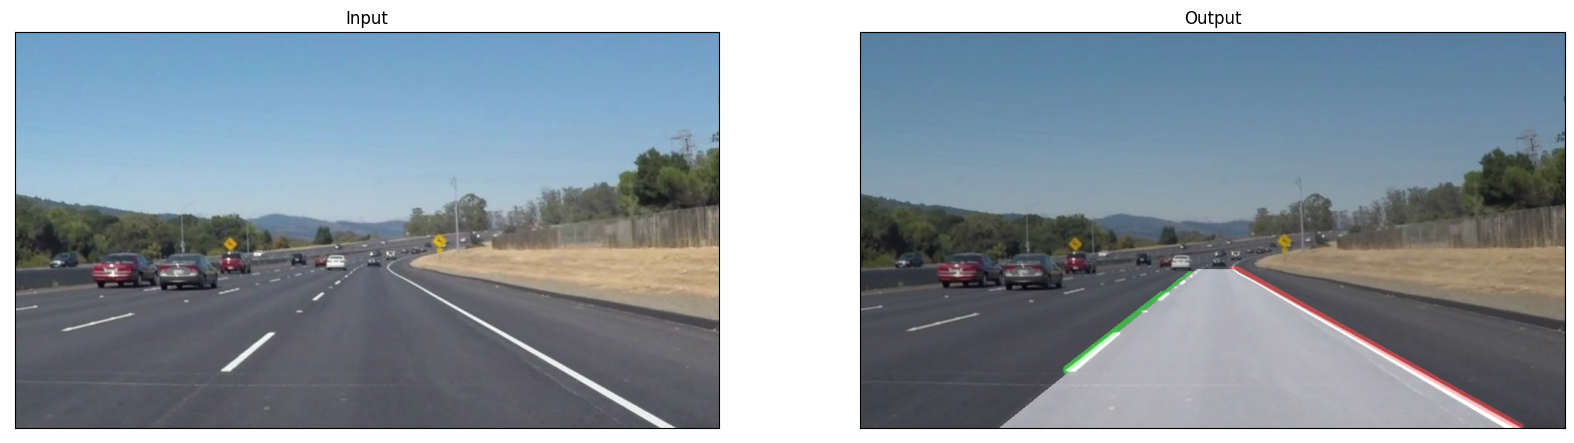

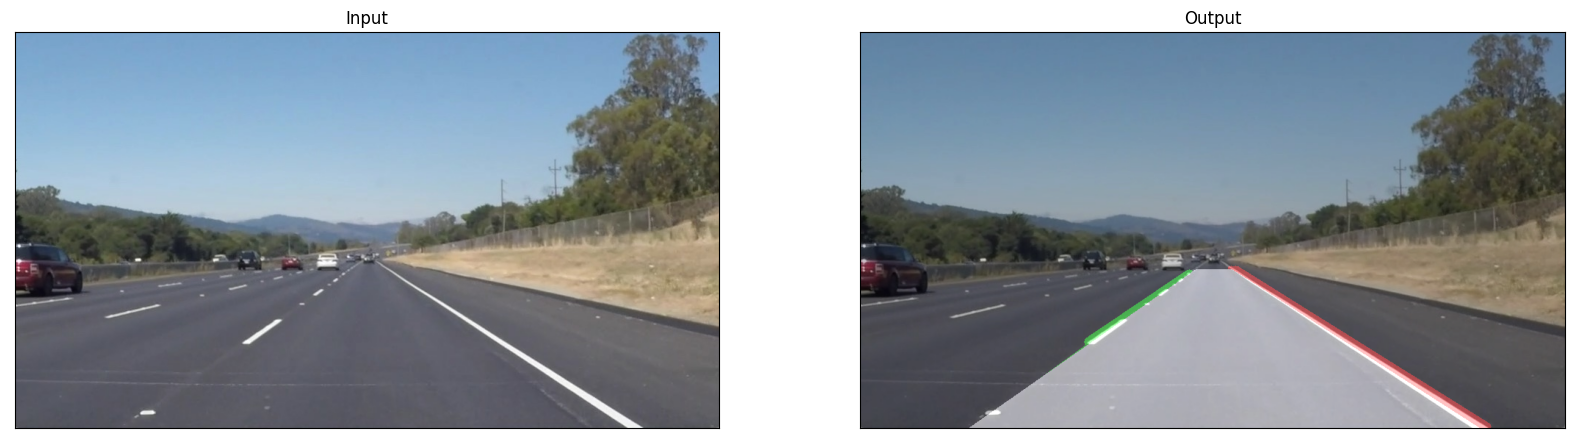

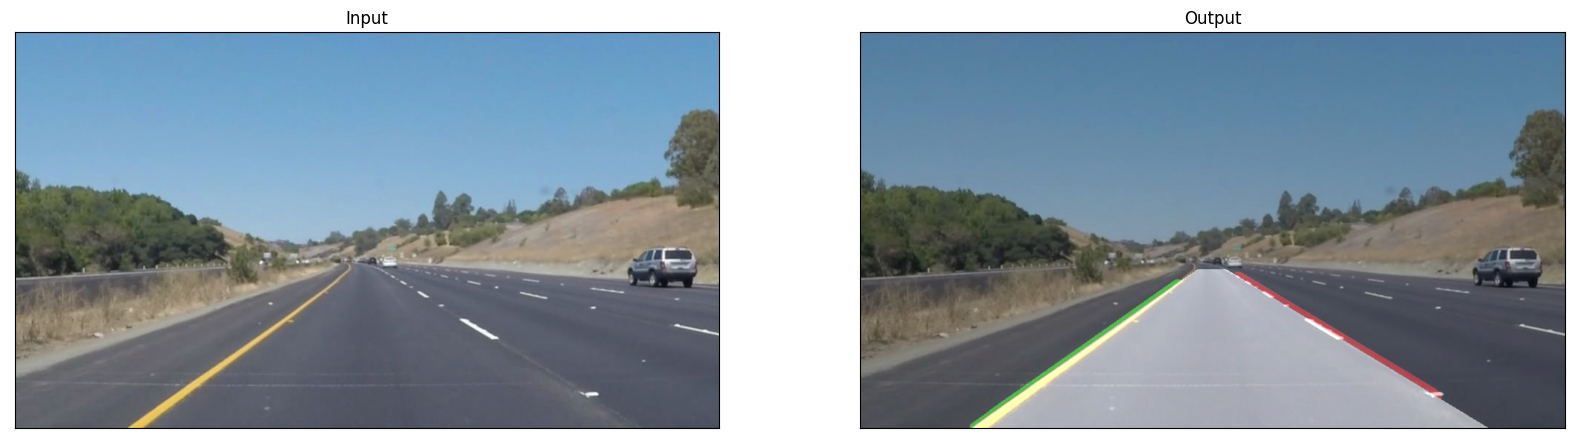

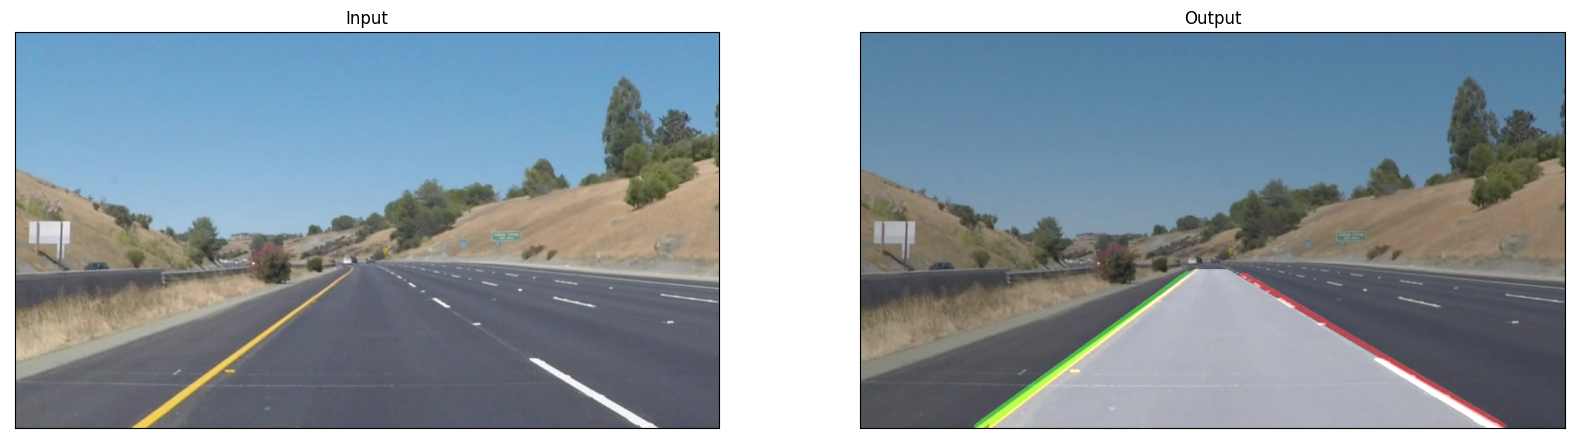

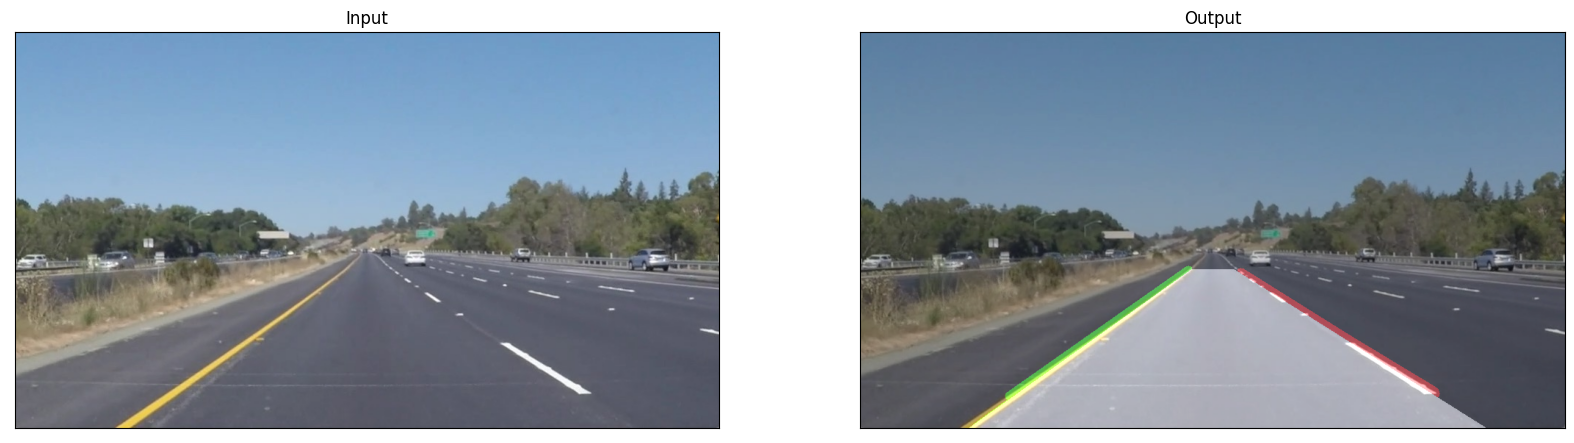

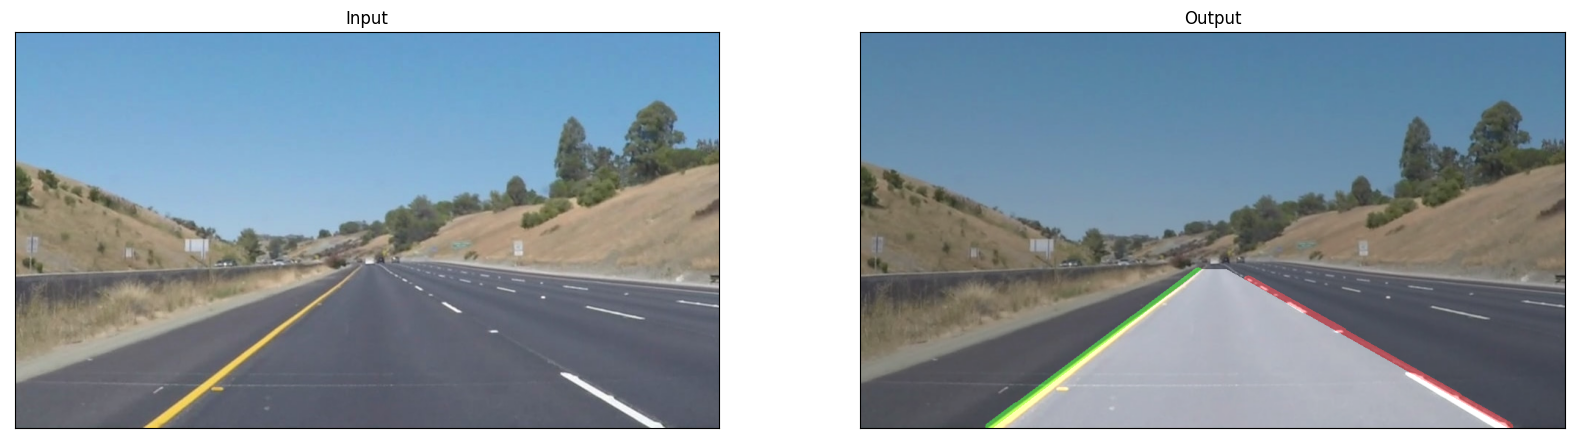

In [174]:
import os
import cv2

for image_path in list(os.listdir('./test_images')):

    image = cv2.imread(f'./test_images/{image_path}')


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title("Input")
    ax1.set_xticks([])
    ax1.set_yticks([])


    ax2.imshow(cv2.cvtColor(detector_de_ligne(image)[0], cv2.COLOR_BGR2RGB))
    ax2.set_title("Output")
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()


Test sur la vidéo


In [175]:
# import cv2

# Ouvrez la vidéo en utilisant cv2.VideoCapture
capture = cv2.VideoCapture("solidWhiteRight.mp4")

# Boucle tant que la vidéo est ouverte
while capture.isOpened():
    # Lisez le cadre actuel de la vidéo
    ret, frame = capture.read()

    # Vérifiez si la vidéo est terminée
    if not ret:
        break

    # Affichez le cadre actuel de la vidéo à l'écran
    
    frame = detector_de_ligne(frame)[0]
    cv2.imshow("Video", frame)

    #Preparer La lecture Audio
    pygame.init()
    pygame.mixer.init()
    # sound.seek(0)

    # Attendre une touche pour mettre en pause/continuer la lecture de la vidéo
    key = cv2.waitKey(30) & 0xff
    if key == 27:  # Appuyez sur Echap pour quitter
        break
    elif key == 32:  # Appuyez sur espace pour mettre en pause/continuer
        cv2.waitKey(0)
    elif key == ord('q'): # Tournez A Gauche
        print("signal à gauche")
        cv2.imwrite("tested.jpg",detector_de_ligne(frame)[1])
        
        image = cv2.imread("tested.jpg")

        # diviser le frzme en deux parties
        height, width, _ = image.shape
        left_half = image[:, :480]
        right_half = image[:, 480:]

        # compter le nombre de pixels blanc 
        left_half_white_pixels = 0
        right_half_white_pixels = 0

        for row in left_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    left_half_white_pixels += 1

        for row in right_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    right_half_white_pixels += 1

        if left_half_white_pixels <538 :
            print("Vous avez le droit au depassement")
            sound = speak("Vous avez le droit au depassement")
            pygame.mixer.music.load(sound, 'mp3')
            pygame.mixer.music.play()
            time.sleep(5)
        else :
            print("Vous avez pas le droit au depassement")
            sound = speak("Vous avez pas le droit au depassement")
            pygame.mixer.music.load(sound, 'mp3')
            pygame.mixer.music.play()
            time.sleep(5)   
        
    elif key == ord('d'): #Tournez A Droite
        print("signal à droite")
        cv2.imwrite("tested.jpg",detector_de_ligne(frame)[1])
        
        image = cv2.imread("tested.jpg")

        
        height, width, _ = image.shape
        left_half = image[:, :480]
        right_half = image[:, 480:]

        
        left_half_white_pixels = 0
        right_half_white_pixels = 0

        for row in left_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    left_half_white_pixels += 1

        for row in right_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    right_half_white_pixels += 1
        print(right_half_white_pixels)
        print(left_half_white_pixels)
        if right_half_white_pixels >538 :
            print("Vous avez pas le droit au depassement")
            sound = speak("Vous avez pas le droit au depassement")
            pygame.mixer.music.load(sound, 'mp3')
            pygame.mixer.music.play()
            time.sleep(5)
        else :
            print("Vous avez le droit au depassement")

            sound = speak("Vous avez le droit au depassement")
            pygame.mixer.music.load(sound, 'mp3')
            pygame.mixer.music.play()
            time.sleep(5)       
        

# Fermez la vidéo et toutes les fenêtres ouvertes
capture.release()
cv2.destroyAllWindows()


C:\Users\HP\AppData\Local\Temp\ipykernel_13680\787165725.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


signal à gauche
Vous avez le droit au depassement


C:\Users\HP\AppData\Local\Temp\ipykernel_13680\787165725.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


signal à droite
677
295
Vous avez pas le droit au depassement


C:\Users\HP\AppData\Local\Temp\ipykernel_13680\787165725.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


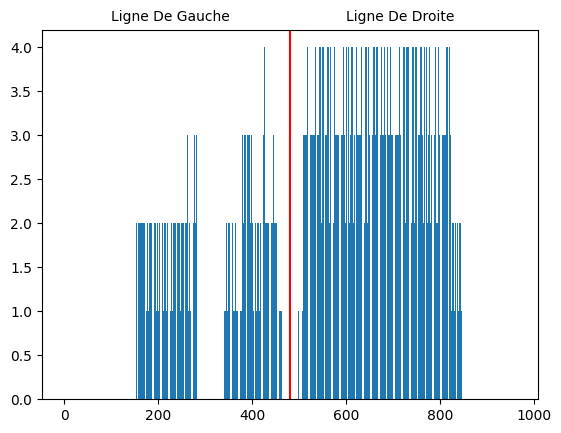

In [176]:
import numpy as np
import matplotlib.pyplot as plt
# Load the image as a NumPy array
image = cv2.imread("tested.jpg")
image = np.array(image)

# Set the threshold for white pixels
white_threshold = 200

# Convert the image to grayscale and threshold it to create a black and white image
gray = np.mean(image, axis=2)
bw = (gray > white_threshold).astype(int)

# Sum the values along the rows to get the count of white pixels for each column
white_pixel_counts = np.sum(bw, axis=0)

# Set the x and y values for the histogram
x = list(range(image.shape[1]))
y = white_pixel_counts

# Create the histogram
plt.bar(x, y)
plt.axvline(x=480, color='r')
plt.text(100, 4.3, 'Ligne De Gauche')
plt.text(600, 4.3, 'Ligne De Droite')
# Show the histogram
plt.show()